In [72]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import networkx as nx
from collections import namedtuple

# Завдання 5
Оцінити кількість розфарбовок графа

In [86]:
def get_neighbours(A, from_node):
    return np.arange(A.shape[0])[A[from_node] != 0]

def get_available_colors(k, adjacent_colors):
    all_colors = set(range(k))
    unavailable = set(adjacent_colors)
    return list(all_colors.difference(unavailable))

def color(A, k, from_node, rng: np.random.Generator):
    # BFS walk.
    n = A.shape[0]
    colors = np.ones(n) * -1
    todo = [ from_node ]
    while len(todo) > 0:
        current = todo.pop()
        neighbours = get_neighbours(A, current)
        a_colors = get_available_colors(k, colors[neighbours])
        if len(a_colors) == 0 and colors[current] == -1:
            raise ValueError("Cannot proceed: no available colors.")
        colors[current] = rng.choice(a_colors)
        for x in neighbours:
            if colors[x] == -1:
                todo.append(x)
    return colors

def random_graph(n, p=0.3):
    A = (np.random.rand(n,n) < p)
    A = (A | A.T) & ((1-np.eye(n)) > 0)
    A = A.astype(np.uint8)
    return A

def draw(A,colors):
    G=nx.to_networkx_graph(A)
    n = A.shape[0]
    Labels = dict(zip(range(n), range(1,n+1)))
    nx.draw_kamada_kawai(G, node_color=colors, labels=Labels, font_color='w')
        

# A - adjacency matrix
# k - кількість кольорів у розфарбовці
Task5Params = namedtuple('Task5Params', 'A,k')
Task5Result = namedtuple('Task5Result', 'nsteps, history, history_per_state')
def Task5(params: Task5Params, n_steps=2000, seed=42, debug=False):
    rng = np.random.default_rng(seed)
    A,k = params
    n = A.shape[0]
    if A.shape[0] != A.shape[1]: raise ValueError("Not square adjacency matrix A")
    if (A != A.T).any(): raise ValueError("Not symmetric adjacency matrix A")
    
    history = []
    all_states = dict()

    # 1. Select random initial coloring
    state = color(A, k, rng.integers(0,n), rng)
    history.append(state)
    all_states[tuple(state)] = 1

    # 2. Змінюємо по одній вершині за раз
    for step in range(n_steps):
        # Рівномірно випадковим чином вибираємо вершину
        node = rng.integers(0,n)
        # Збираємо список доступних кольорів
        neighbours = get_neighbours(A, node)
        a_colors = get_available_colors(k, state[neighbours])
        # Вибираємо новий колір рівномірно випадково з доступних
        state[node] = rng.choice(a_colors)
        # Додаємо новий стан в історію
        history.append(state)
        # Збільшуємо лічильник заходів у цей стан
        st = tuple(state)
        if st in all_states:
            all_states[st] += 1
        else:
            all_states[st] = 1

        
    return Task5Result(n_steps, history, all_states)


Беремо граф із завдання

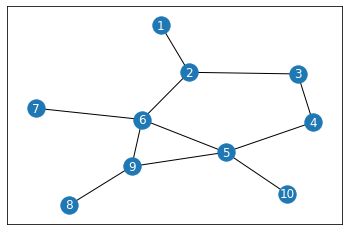

In [80]:
def get_graph_from_book():
    A = np.zeros((10,10))
    edges = [
        (1,2), (2,3), (3,4), (2,6), (4,5), (6,5), (5,10), (6,7), (6,9), (5,9), (8,9)
    ]
    for (i,j) in edges:
        A[i-1,j-1] = 1
        A[j-1,i-1] = 1
    return A

A = get_graph_from_book()
G = nx.from_numpy_array(A)
Gpos = nx.kamada_kawai_layout(G)
Labels = dict(zip(range(10), range(1,11)))
nx.draw_networkx(G, Gpos, labels=Labels, with_labels=True, font_color='w')

## Перший запуск. k=3

In [127]:
param3 = Task5Params(A, k=3)
result3 = Task5(param3, n_steps=100000, seed=1000)

Граф у форматі Wolfram Mathematica

In [128]:
for i,j in [ (1,2), (2,3), (3,4), (2,6), (4,5), (6,5), (5,10), (6,7), (6,9), (5,9), (8,9)]:
    print(f"{i}<->{j},", end="")

1<->2,2<->3,3<->4,2<->6,4<->5,6<->5,5<->10,6<->7,6<->9,5<->9,8<->9,

Кінцеве розфарбування

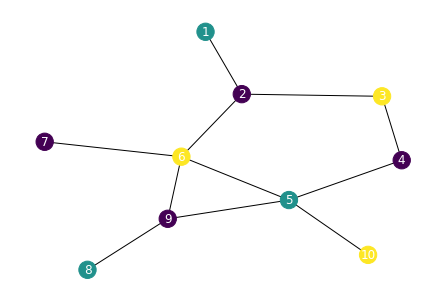

In [129]:
draw(A, result3.history[-1])

Кількість різних розфарбувань

In [130]:
n_colorings3 = result3.history_per_state.keys()
print(f"Всього виявлено {len(n_colorings3)} різних розфарбувань")

Всього виявлено 64 різних розфарбувань


### Результати для k=3 

1. Маємо **64** різних розфарбувань для n=10000,20000,50000 та 100000 з різними початковими значеннями генератора псевдовипадкових чисел.

2. При цьому іншими методами можна отримати точне значення у 80 розфарбувань. Наприклад, тут я використав Wolfram Mathematica
![Alt text](Colorings1.png)

(ділення на $3!$ в кінці бо воно рахує враховуючи також всі можливі обміни кольорів місцями)

> Істинне значення - **480** розфарбувань (або **80** не враховуючи обмін кольорів)

Text(0.5, 1.0, 'Гістограма для розфарбувань із k=3')

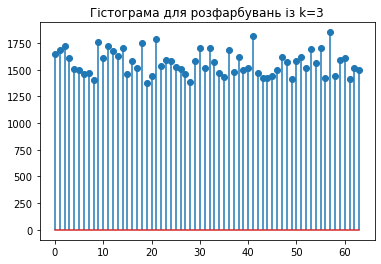

In [142]:
plt.stem(range(len(result3.history_per_state)), result3.history_per_state.values())
plt.title('Гістограма для розфарбувань із k=3')

Тим не менш, бачимо щось близьке до рівномірного розподілу

## Другий запуск. k=4

In [151]:
param = Task5Params(A, k=4)
result = Task5(param, n_steps=500000, seed=1000)

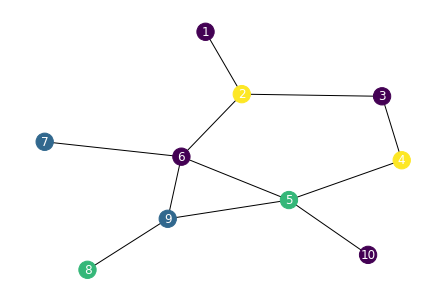

In [152]:
draw(A, result.history[-1])

In [153]:
n_colorings = result.history_per_state.keys()
print(f"Всього виявлено {len(n_colorings)} різних розфарбувань")

Всього виявлено 38715 різних розфарбувань


Text(0.5, 1.0, 'Гістограма для розфарбувань із k=4')

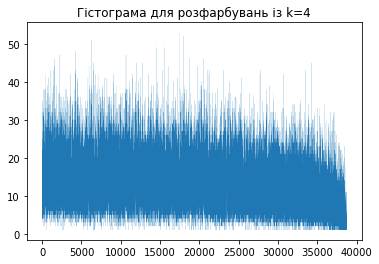

In [154]:
plt.plot(range(len(result.history_per_state)), result.history_per_state.values(), lw=0.1)
plt.title('Гістограма для розфарбувань із k=4')

### Результати для k=4
1. Для n=100000 виявлено **26293** розфарбувань.
2. Для n=200000 виявлено **34692** розфарбувань.
3. Для n=300000 виявлено **37530** розфарбувань.
4. Для n=500000 виявлено **38715** розфарбувань.
5. Кількість розфарбувань, обчислена у Wolfram - **38880**.  
    ![Alt text](Colorings4.png)

# Підсумки

1. Для малих графів алгоритм точно займає значно більше часу, ніж інші (аналітичні) методи підрахунку кількості розфарбувань з теорії графів.  

    Один альтернативний спосіб - побудова хроматичного поліному $P$ та обчислення його значення $P(k)$ для $k$ кольорів.  
    
2. Для $k=3$ я не зміг отримати результат, близький до дійсного. 
      
    Оскільки ми змінюємо по одній вершині за раз, можуть бути ситації, коли ніякі нові розфарбування вже не можливі. Тобто, це ситуація, подібна до застрягання у локальному мінімумі.  
    У нашому випадку все навіть гірше: k=3 означає, що ми можемо  змінити колір лише вершин із одним ребром, тобто "листків" - це накладає обмеження на можливі пермутації розфарбувань.  
    Тут можна досліджувати далі (наприклад, перевірити ці гіпотези, знайшовши розфарбування, яке не знайшов мій марковий ланцюг), але, на жаль, зараз вже кінець семестру та я не встигаю. 

3. Для $k=4$ ситуація набагато краще. В нашому графі не зустрічаються підграфи із хроматичним числом вище 3, отож для будь-якої вершини завжди можлива зміна кольору. Це означає, що простір розфарбувань є зв'язним і рано чи пізно ми обійдемо його повністю.  
  
    Також бачимо наскільки збіжність до істинного значення повільна

    З іншого боку, бачимо, що ланцюг рахує розфарбування враховуючи обміни кольорів. Отож для підрахунку не враховуючи ці обміни, знадобиться ділити на $k!$ або іншим чином ототожнювати еквівалентні розфарбування.